code to produce diurnal cycle of temperature, humidity, lhf and shf
author: Claudia Acquistapace
date: 16 Nov 2021


<ipython-input-6-5e850e23bba2>:108: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs.pcolormesh(pd.to_datetime(arthus_data['Time'].values), arthus_data['Height'].values, \


AttributeError: 'function' object has no attribute 'dtype'

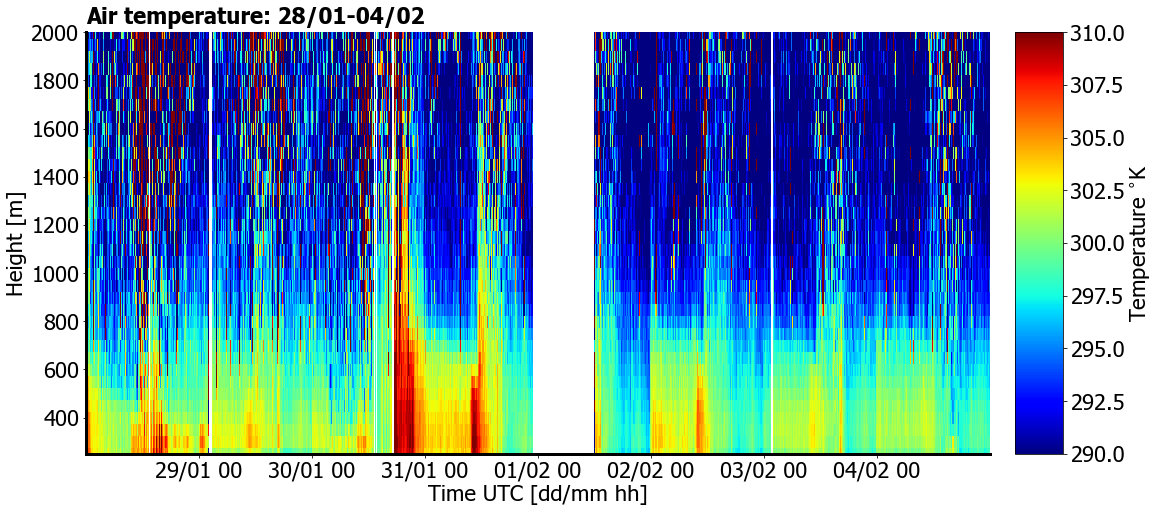

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker


# output paths
path_out = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings to be used
labelsizeaxes   = 14
fontSizeTitle   = 16
fontSizeX       = 16
fontSizeY       = 16
cbarAspect      = 10
fontSizeCbar    = 16
rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams['savefig.dpi'] = 100
plt.rcParams.update({'font.size':22})
grid = True

# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'WVMR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]


for ind_var,var_name in enumerate(var_list):
    
    # read dictionary for the variable
    dict_var = dict_list[ind_var]
    
    # paths
    data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+var_name+'/'

    arthus_files = np.sort(glob.glob(data_path+'*.cdf'))
    
    # merging data from each day in a single xarray dataset
    arthus_data = xr.open_mfdataset(arthus_files)
        
    # plot of merged data time serie
    fig, axs = plt.subplots(1, 1, figsize=(16,7), constrained_layout=True)
    axs.get_yaxis().tick_left()
    axs.get_xaxis().tick_bottom() 
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    
    mesh = axs.pcolormesh(pd.to_datetime(arthus_data['Time'].values), arthus_data['Height'].values, \
                             arthus_data['Product'].values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

    cbar = fig.colorbar(mesh, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H'))
    axs.set_ylim(250., 2000.)
    axs.set_xlabel('Time UTC [dd/mm hh]')
    axs.set_ylabel('Height [m]')
    axs.text(0, 1.02, dict_var['title'],  fontweight='black', transform=axs.transAxes)
    fig.savefig(path_out+'{var_name}_time_serie.png'.format(**dict_var))



    # diurnal cycle calculation: averaging the data on the time resolution of the diurnal cycle and then grouping

    # calculating the mean of the variable over the time interval requested
    arthus_data = arthus_data.resample(Time=dict_var['avg_time']+'T').mean()

    # re-writing time array as hh:mm for then being able to group
    arthus_data['Time'] = pd.to_datetime(arthus_data.Time.values).strftime("%H:%M")

    # grouping and calculating mean of the profiles
    grouped_mean = arthus_data.groupby('Time').mean()
    grouped_std = arthus_data.groupby('Time').std()
    
    # plot figure of the diurnal cycle variable
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
    #ax.tick_params(which='minor', length=7, width=3)
    #ax.tick_params(which='major', length=7, width=3)

    mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \
                             grouped_mean['Product'].values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.set_ylim(250., 2000.)
    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
            fontweight='black', transform=axs.transAxes)
    fig2.savefig(path_out+'{var_name}_diurnal_cycle.png'.format(**dict_var))


In [3]:
arthus_files = np.sort(glob.glob(data_path+'*.cdf'))



In [33]:
arthus_files
merged = xr.open_mfdataset(arthus_files)

In [34]:
merged

<xarray.Dataset>
Dimensions:               (Height: 57, Time: 1160)
Coordinates:
  * Time                  (Time) datetime64[ns] 2020-01-28 ... 2020-02-05
  * Height                (Height) float32 225.0 275.0 325.0 ... 2975.0 3025.0
Data variables:
    Latitude              (Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Longitude             (Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ZSL                   (Time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Emission_Wavelength   (Time) float64 354.7 354.7 354.7 ... 354.7 354.7 354.7
    Range_Resolution      (Time) float32 50.0 50.0 50.0 50.0 ... 50.0 50.0 50.0
    Elevation             (Time) float64 dask.array<chunksize=(145,), meta=np.ndarray>
    Elevation_Resolution  (Time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Azimuth               (Time) float64 dask.array<chunksize=(145,), meta=np.ndarray>
    Azimuth_Resolution    (Time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Product               (Time, Height) float32 dask.array<chunksize=(145, 57), meta=np.ndarray>
Attributes:
    Title:            Latent heat flux (W/m^2)
    Campaign_name:    Eurec4a 2020
    Location_name:    Barbados - Atlantic Ocean
    Source:           ARTHUS - UHOH Doppler lidar
    Institution:      University of Hohenheim, Institute of Physics and Meteo...
    Contact_person:   Diego Lange (diego.lange@uni-hohenheim.de)
    Processed_by:     Diego Lange (diego.lange@uni-hohenheim.de)
    Processing_date:  Fri Oct 15 14:52:12 2021 UTC
    Conventions:      basing on CF-1.6
    History:          Data processed at UHOH version 1. For comparison purpos...
    Version:          1.0

<xarray.Dataset>
Dimensions:               (Height: 57, Time: 385)
Coordinates:
  * Time                  (Time) datetime64[ns] 2020-01-28 ... 2020-02-05
  * Height                (Height) float32 225.0 275.0 325.0 ... 2975.0 3025.0
Data variables:
    Latitude              (Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Longitude             (Time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ZSL                   (Time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Emission_Wavelength   (Time) float64 354.7 354.7 354.7 ... 354.7 354.7 354.7
    Range_Resolution      (Time) float32 50.0 50.0 50.0 50.0 ... 50.0 50.0 50.0
    Elevation             (Time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Elevation_Resolution  (Time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Azimuth               (Time) float64 -999.0 -999.0 -999.0 ... nan nan nan
    Azimuth_Resolution    (Time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1
    Product               (Time, Height) float32 1.6384674 8.078184 ... nan nan

<ipython-input-36-68e01ac21128>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = ax.pcolormesh(pd.to_datetime(time), height, LHF.T, cmap='jet', vmin=-20., vmax=150., rasterized=True)


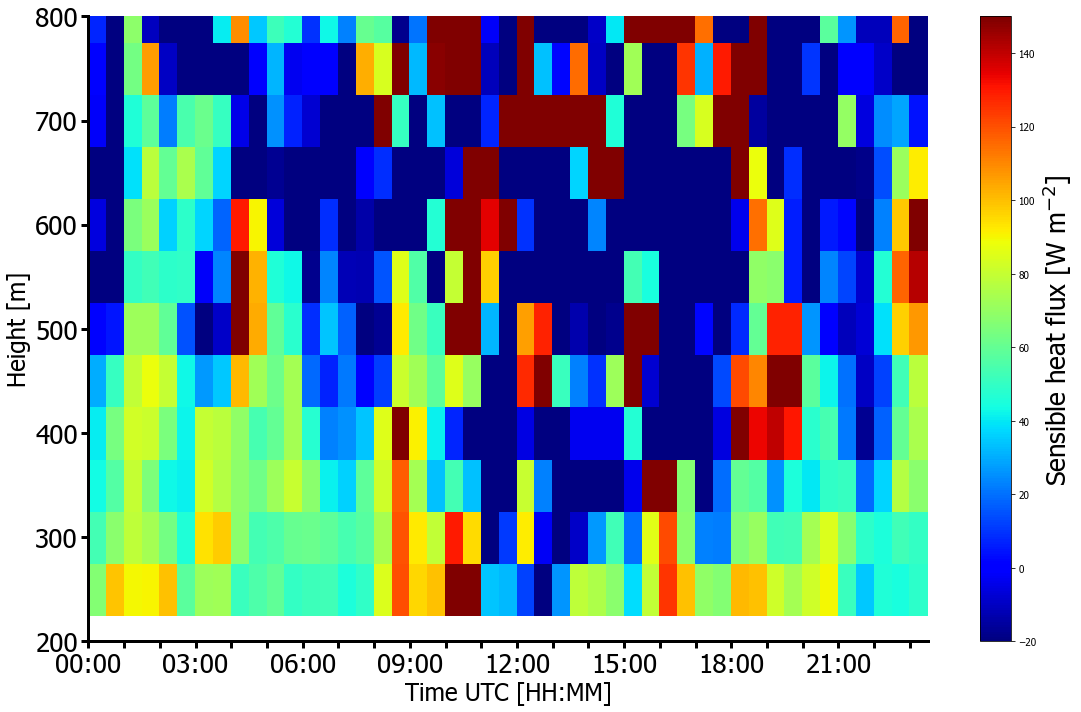

In [36]:
# reading variables for the plot and deriving the plot
SHF = grouped_mean.Product.values
time = grouped_mean.Time.values
height = grouped_mean.Height.values
var_name ='SHF'

labelsizeaxes   = 26
fontSizeTitle   = 26
fontSizeX       = 26
fontSizeY       = 26
cbarAspect      = 26
fontSizeCbar    = 26





<ipython-input-4-90f851dc2fc3>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)


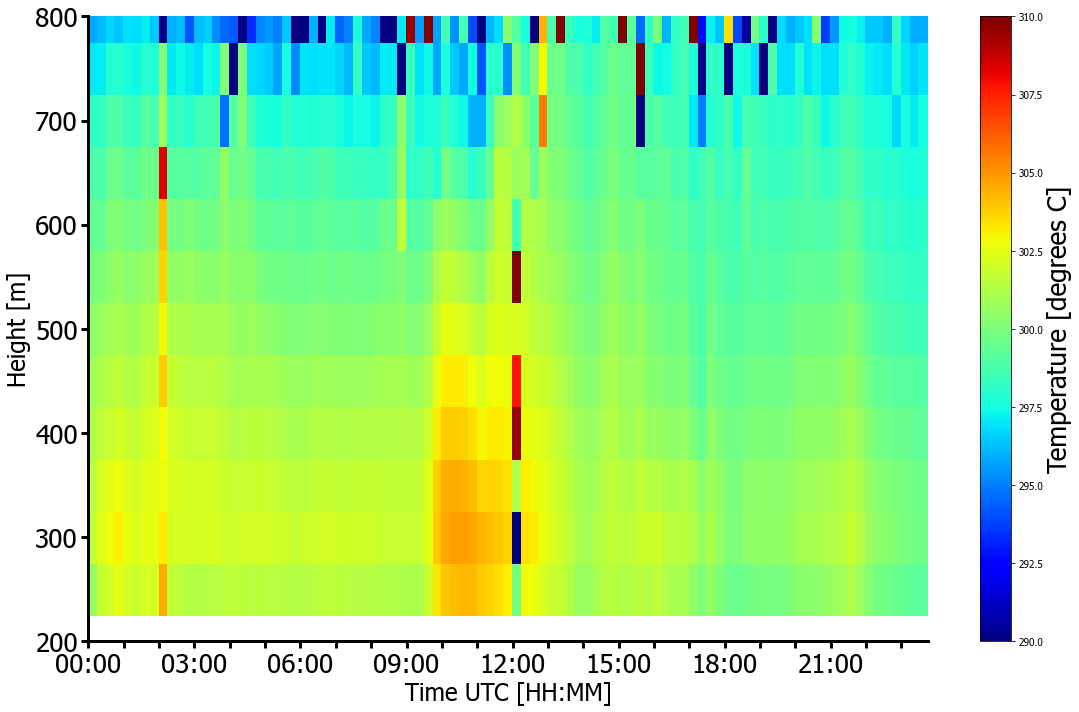

In [4]:
# reading variables for the plot and deriving the plot
T = grouped_mean.Product.values
time = grouped_mean.Time.values
height = grouped_mean.Height.values


labelsizeaxes   = 26
fontSizeTitle   = 26
fontSizeX       = 26
fontSizeY       = 26
cbarAspect      = 26
fontSizeCbar    = 26
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams['savefig.dpi'] = 100
plt.gcf().subplots_adjust(bottom=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
ax.tick_params(which='minor', length=7, width=3)
ax.tick_params(which='major', length=7, width=3)

#ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.tick_params(axis='both', labelsize=26)

mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)
ax.set_xlabel('Time UTC [HH:MM]', fontsize=24)
ax.set_ylabel('Height [m]', fontsize=24)
ax.set_ylim(200., 800.)
cbar = fig.colorbar(mesh1, use_gridspec=True)
cbar.set_label(label='Temperature [degrees C]',  size=26)

fig.tight_layout()
fig.savefig(path_out+'T_diurnal_cycle.png')


<ipython-input-41-54a0cdcfe7d0>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)


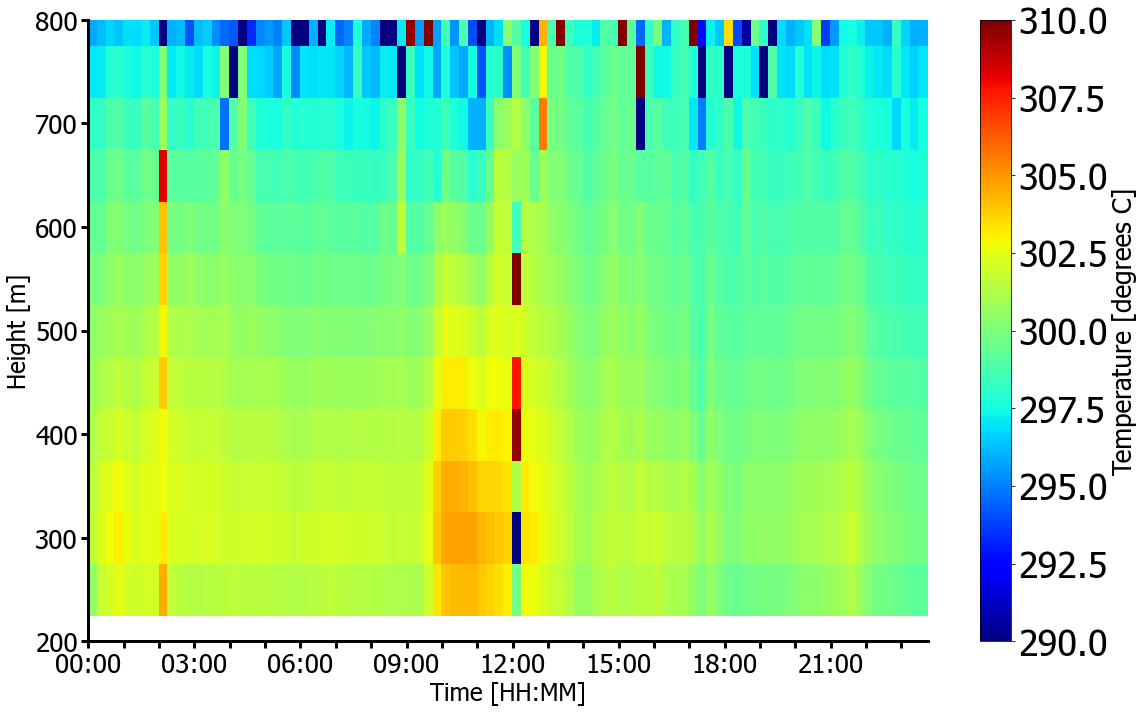